# Transverse Ising chain with linear dissipation

In [1]:
include("notebook_preamble.jl")

## Spins

First, we set up the spin-1/2 sites and Pauli operators.

In [2]:
b = SpinBasis(1//2)
I = identityoperator(b)
sx, sy, sz, sp, sm = sigmax(b), sigmay(b), sigmaz(b), sigmap(b), sigmam(b)
up, down = spinup(b), spindown(b)
ψx = eigenstates(dense(sx))[2][1]
tpow(x, n) = ⊗(repeat([x], n)...);

## Bosons

In [3]:
bosons = 2 # Cutoff for numerics
f = FockBasis(bosons)
a, at = destroy(f), create(f)
n = number(f);

We define a finite number of frequencies with an upper cutoff, since additional noninteracting bosons are extraneous.

In [4]:
ωs = 2
ω(k) = k
Bb = tpow(f, ωs);

## Ising model

To create a $N$-site spin loop, we need to construct the basis for the loop and operators for each site.

In [5]:
spins = 2
Bs = tpow(b, spins)
site(i, op) = embed(Bs, (i-1)%spins + 1, op); # Periodic boundary

We now construct the transverse-field Ising Hamiltonian
$$
\ham
= -\sum_{i=1}^N J_i \pauli_{zi} \pauli_{z(i+1)} - \sum_i h_i \pauli_{xi}.
$$

In [39]:
Jh = 0.2
J = Jh*ones(spins)
# h = ones(spins)
h = zeros(spins)
Hs = -sum(J[i]*site(i, sz)*site(i+1, sz) + h[i]*site(i, sx) for i in 1:length(h));

## Linearly dissipative interaction with boson bath

We construct a harmonic bath which affects linear (Caldeira-Leggett) dissipation.

In [40]:
α = 0.6
Γ(k) = α*ω(k) / 2
Bbs = tpow(Bb, spins)
mode(i, k, op) = embed(Bbs, ((i-1)%spins + 1)*k, op); # Site-periodic boundary

In [41]:
Hi = sum(Γ(k)*mode(i, k, at + a) ⊗ site(i, sz) for k in 1:ωs for i in 1:spins)
Hb = sum(ω(k)*mode(i, k, n) for k in 1:ωs for i in 1:spins)
H = (one(Bbs) ⊗ Hs) + (Hb ⊗ one(Bs)) + Hi;
size(H)

(324, 324)

## Time evolution

We start the system off with the bosons in coherent states and all spins down.

In [101]:
λ = 1.0
# ψs = tpow(spindown(b), spins)
ψs = tpow(ψx, spins)
ψb = tpow(coherentstate(f, λ), ωs*spins)
ψ0 = normalize(ψb ⊗ ψs);

Now we time-evolve the system and look at the expectation values of some reduced operators on the spin chain. We start with just the isolated chain.

In [102]:
fout(t, ρ) = real([
        expect(site(1, sz), ρ)
        expect(embed(Bs, [1, 2], [sz, sz]), ρ)
        expect(site(1, sx), ρ)
        ])
ts, fouts = timeevolution.schroedinger([0:0.05:20;], ψs, Hs, fout=fout);

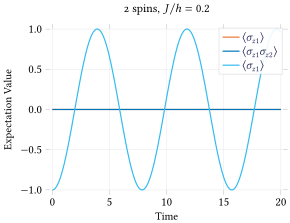

In [103]:
plot(xlabel="Time", ylabel="Expectation Value")
plot!(ts, hcat(fouts...)',
    title = latexstring("$spins spins, \$J/h = $Jh\$"),
    label = [
        L"\left\langle\pauli_{z1}\right\rangle"
        L"\left\langle\pauli_{z1}\pauli_{z2}\right\rangle"
        ])

Now for the interacting system:

In [104]:
fout(t, ρ) = real([
        expect(one(Bbs) ⊗ site(1, sz), ρ)
        expect(one(Bbs) ⊗ embed(Bs, [1, 2], [sz, sz]), ρ)
        expect(one(Bbs) ⊗ site(1, sx), ρ)
        ])
ts, fouts = timeevolution.schroedinger(ts, ψ0, H, fout=fout);

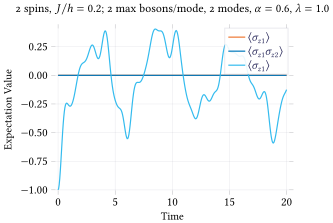

In [105]:
plot(xlabel="Time", ylabel="Expectation Value")
plot!(ts, hcat(fouts...)',
    title = latexstring("$spins spins, \$J/h = $Jh\$; $bosons max bosons/mode, $ωs modes, \$\\alpha = $α\$, \$\\lambda = $λ\$"),
    label = [
        L"\left\langle\pauli_{z1}\right\rangle"
        L"\left\langle\pauli_{z1}\pauli_{z2}\right\rangle"
        ])

## Markovian secondary environment for bath

We now consider the possibility that bosons interact with another environment at rate $\gamma$, so we have the jump operators (?)
\begin{equation}\label{eq:jaynes-cummings-jump}
\opr{J}_{ik}
= \sqrt{\gamma}\opr{a}_{ik} \qand \sqrt{\gamma}\opr{a}_{ik}^\dagger.
\end{equation}

In [106]:
γ = 5e-2
Js = vcat([√(γ) .* [mode(i, k, a) ⊗ one(Bs), mode(i, k, at) ⊗ one(Bs)]
        for i in 1:spins for k in 1:ωs]...);

The corresponding master equation is then
\begin{equation}\label{eq:jaynes-cummings-damped}
\dot\dop
= \frac{\comm{\ham}{\dop}}{\im\hbar} + \sum_{ik} \opr{J}_{ik}\dop\opr{J}_{ik}^\dagger - \frac{\acomm{\opr{J}_{ik}^\dagger\opr{J}_{ik}}{\dop}}{2}.
\end{equation}

In [107]:
ρ0 = projector(ψ0)
ts, fouts = timeevolution.master(ts, ρ0, H, Js, fout=fout);

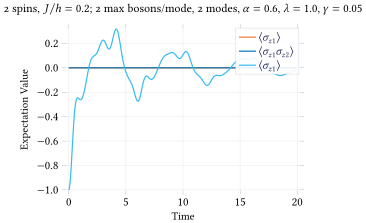

In [108]:
plot(xlabel="Time", ylabel="Expectation Value")
plot!(ts, hcat(fouts...)',
    title = latexstring("$spins spins, \$J/h = $Jh\$; $bosons max bosons/mode, $ωs modes, \$\\alpha = $α\$, \$\\lambda = $λ\$, \$\\gamma = $γ\$"),
    label = [
        L"\left\langle\pauli_{z1}\right\rangle"
        L"\left\langle\pauli_{z1}\pauli_{z2}\right\rangle"
        ])

## Other computations

In [109]:
thermalstate(n, 1)
# real(expect(at + a, thermalstate(n, 10)))

Operator(dim=3x3)
  basis: Fock(cutoff=2)
 0.665241+0.0im       0.0+0.0im        0.0+0.0im
      0.0-0.0im  0.244728+0.0im        0.0+0.0im
      0.0-0.0im       0.0-0.0im  0.0900306+0.0im

In [110]:
fockstate(f, 1)

Ket(dim=3)
  basis: Fock(cutoff=2)
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im